## Requirements

In [17]:
# Import all required libraries
import yfinance as yf
import numpy as np
i = complex(0,1)
np.random.seed(8309)

# Import all functions from custom modules
from Load_data_yfiance import get_Today_data, save_to_csv, read_from_csv
from Fit_interp_regres import get_interp
from plot_2_interp import plot_two_interp
from plot_loc_vol_surface import plot_local_vol_surface
from heston import heston_simulation, fit_Heston_model
from garch import Garch_simulation,get_param_garch
from dupire import get_local_vol_surface, dupire_simulation
from BaseLineGBM import GBM_simulation
from plot_result import plot_s_paths,plot_v_paths,plot_log_norm,plot_CI

## Load Data

In [18]:
ticker = "^SPX"
spx = yf.Ticker(ticker)
r = 0.045

calls,date = get_Today_data(Ticker = spx, r = r)
save_to_csv(calls,date)
# calls = read_from_csv("2025-10-28")

print("range of strike: ",calls["strike"].min(),calls["strike"].max())
print("range of ttm: ",calls["ttm"].min(),calls["ttm"].max())
print("number of options: ",calls.size)
calls.head()

range of strike:  5300.0 7060.0
range of ttm:  0.003968253968253968 0.21825396825396826
number of options:  1534


,strike,lastPrice,lastTradeDate,CP,exp,S0,ttm,exp_month,r,in_out,F,q,imp_vol
1,5300.0,1499.96,2025-11-06 04:49:14+00:00,0,2025-11-07,6796.290039,0.003968,2511,0.045,in,6789.148062,0.309957,1.748670
5,6750.0,57.10,2025-11-06 01:30:16+00:00,0,2025-11-07,6796.290039,0.003968,2511,0.045,in,6789.148062,0.309957,0.158365
6,6755.0,56.30,2025-11-06 01:15:00+00:00,0,2025-11-07,6796.290039,0.003968,2511,0.045,in,6789.148062,0.309957,0.178846
7,6760.0,49.90,2025-11-06 01:30:16+00:00,0,2025-11-07,6796.290039,0.003968,2511,0.045,in,6789.148062,0.309957,0.159275
8,6790.0,34.90,2025-11-06 02:58:35+00:00,0,2025-11-07,6796.290039,0.003968,2511,0.045,in,6789.148062,0.309957,0.181629


# Methods

## Base Line: Constant Vol GBM

In [19]:
spx = yf.download(ticker, period='31d')
spx['returns'] = np.log(spx['Close'] / spx['Close'].shift(1))
vol = spx['returns'].dropna().std()
vol_annual = vol * np.sqrt(252)
mu = spx['returns'].dropna().mean()
mu_annual = mu * 252
print("Annualized 30-days Mean:",mu_annual)
print("Annualized 30-days Volatility:",vol_annual)

[*********************100%***********************]  1 of 1 completed

Annualized 30-days Mean: 0.1979934985315015
Annualized 30-days Volatility: 0.12782294292789761


## Local Volitality Method

### Get Interpolation and Regression (as comparison)

In [20]:
interp,regres = get_interp(calls)
plot_two_interp(interp,regres,calls)

### Find and Plot Local Volitality

#### Local Vol using Interpolation

In [21]:
impvol_interp = interp
params = [calls["S0"].iloc[0],calls["r"].iloc[0],impvol_interp]
local_vol_surface = get_local_vol_surface(calls,params)
plot_local_vol_surface(calls,local_vol_surface)

#### local Vol using regression

In [22]:
impvol_interp = regres
params = [calls["S0"].iloc[0],calls["r"].iloc[0],impvol_interp]
local_vol_surface_ = get_local_vol_surface(calls,params)
plot_local_vol_surface(calls,local_vol_surface_)

## Heston Method

In [23]:
v0,kappa,theta,rho,sigma = fit_Heston_model(calls)
print("initial variance under risk-neutral dynamics")
print("v0:", v0)
print("rate of mean reversion of variance under risk-neutral dynamics")
print("kappa:", kappa)
print("long-term mean of variance under risk-neutral dynamics")
print("theta:", theta)
print("correlation between returns and variances under risk-neutral dynamics")
print("rho:", rho)
print("volatility of volatility")
print("sigma:", sigma)

initial variance under risk-neutral dynamics
v0: 0.02
rate of mean reversion of variance under risk-neutral dynamics
kappa: 2.0
long-term mean of variance under risk-neutral dynamics
theta: 0.02
correlation between returns and variances under risk-neutral dynamics
rho: -0.5
volatility of volatility
sigma: 0.02


## Garch Method

In [24]:
omega, alpha, beta = get_param_garch(ticker)
print("Omega:",omega)
print("Alpha:",alpha)
print("Beta:",beta)

[*********************100%***********************]  1 of 1 completed

Omega: 7.983814109427158e-06
Alpha: 0.04999999831833821
Beta: 0.899999999547471


# Path Simulated And Results Comparison

## Set Up parameters

In [41]:
# Exercise price
K = 7500
# time in years
T = 0.5
# number of time steps in simulation
N = int(T*252)
# asset price
S0 = calls["S0"].iloc[0]
# risk-free rate
r = calls["r"].iloc[0]
# Divident rate
q = 0
# number of simulations
M = 5000


## Plot Paths

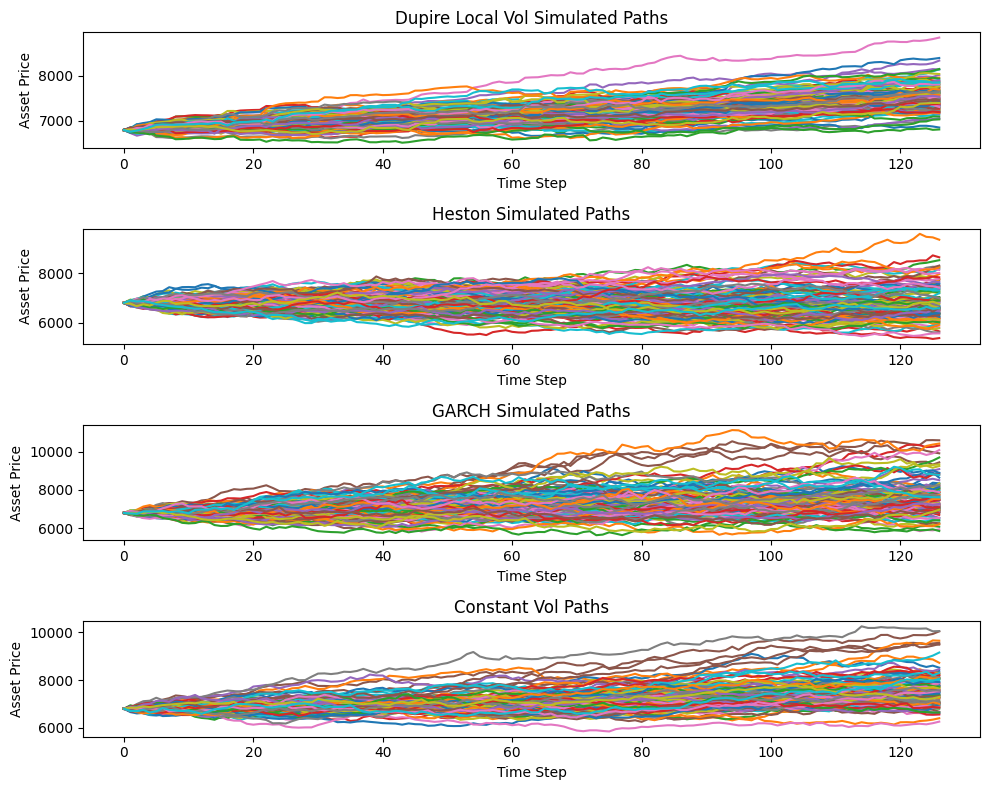

In [42]:
S_path_Heston,V_path_Heston = heston_simulation(S0=S0,r=r,q=q,K=K,T=T,v0=v0,kappa=kappa,theta=theta,rho=rho,sigma=sigma,M=M,N=N)
S_path_dupire,V_path_dupire = dupire_simulation(mu_annual=mu_annual,K=K,S0=S0,T=T,N=N,M=M, params=[calls["S0"].iloc[0],calls["r"].iloc[0],interp])
S_path_Garch, V_path_Garch = Garch_simulation(omega=omega, alpha=alpha, beta=beta,mu_annual=mu_annual,vol_annual=vol_annual,N=N,M=M,S0=S0,T=T)
S_path_GBM, V_path_GBM = GBM_simulation(vol_annual=vol_annual,mu_annual=mu_annual,S0=S0,T=T,N=N,M=M)

plot_s_paths(S_path_dupire,S_path_Heston,S_path_Garch,S_path_GBM,m=100)


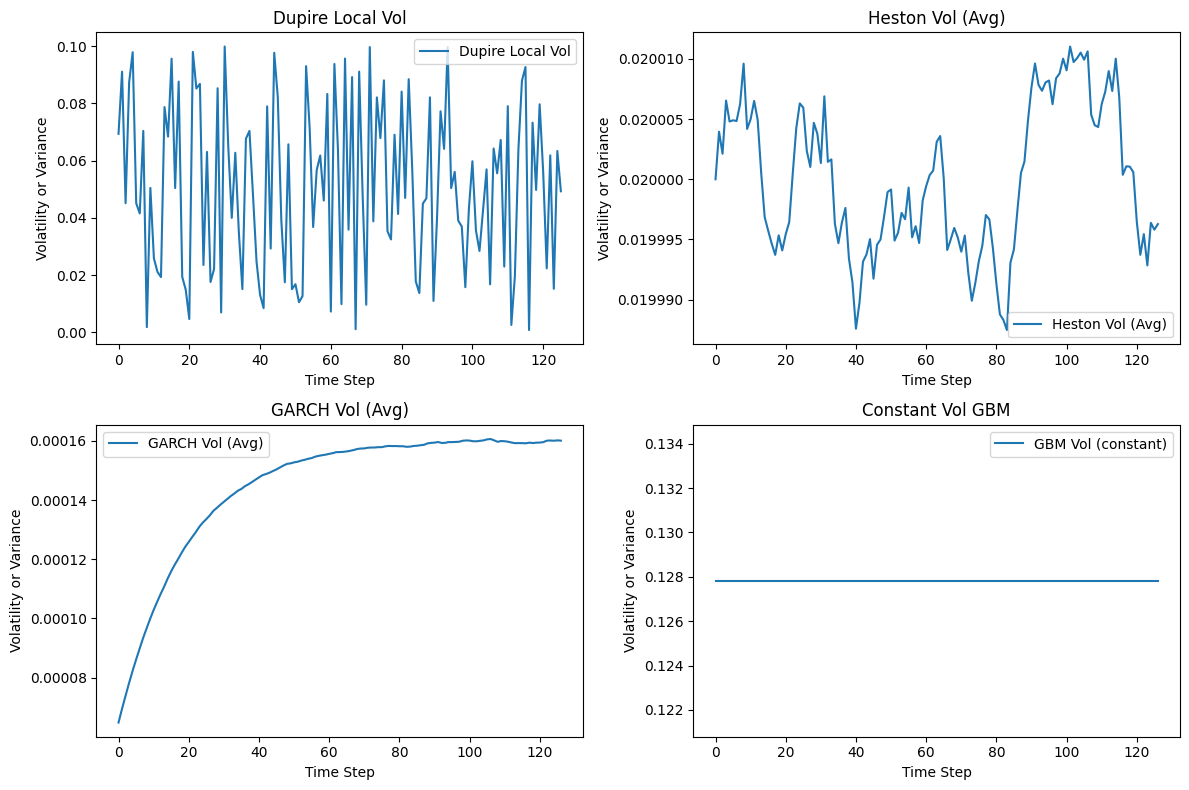

In [43]:
plot_v_paths(V_path_dupire,V_path_Heston,V_path_Garch,V_path_GBM)

## Plot PAYOFF Distribution

In [44]:
def payout(path,K):
    return np.maximum(path[-1,:]-K,0)

def DCF(payout,r,T):
    return payout*np.exp(-r*T)
    
local_vol_payouts = payout(S_path_dupire,K)
heston_payouts = payout(S_path_Heston,K)
Garch_Vol_payouts = payout(S_path_Garch,K)
Constant_vol_payouts = payout(S_path_GBM,K)

local_vol_val = DCF(local_vol_payouts,r,T)
heston_val = DCF(heston_payouts,r,T)
Garch_Vol_val = DCF(Garch_Vol_payouts,r,T)
Constant_vol_val = DCF(Constant_vol_payouts,r,T)

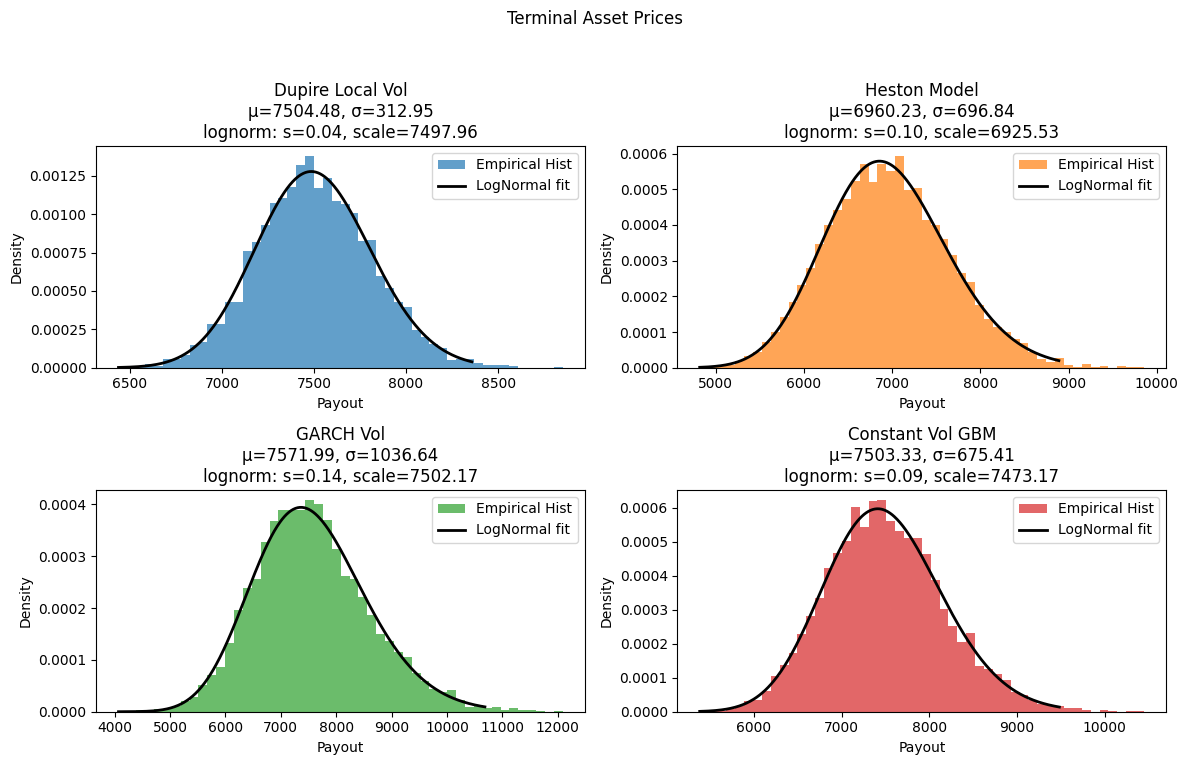

In [45]:
plot_log_norm(S_path_dupire[-1,:],S_path_Heston[-1,:],S_path_Garch[-1,:],S_path_GBM[-1,:],'Terminal Asset Prices')

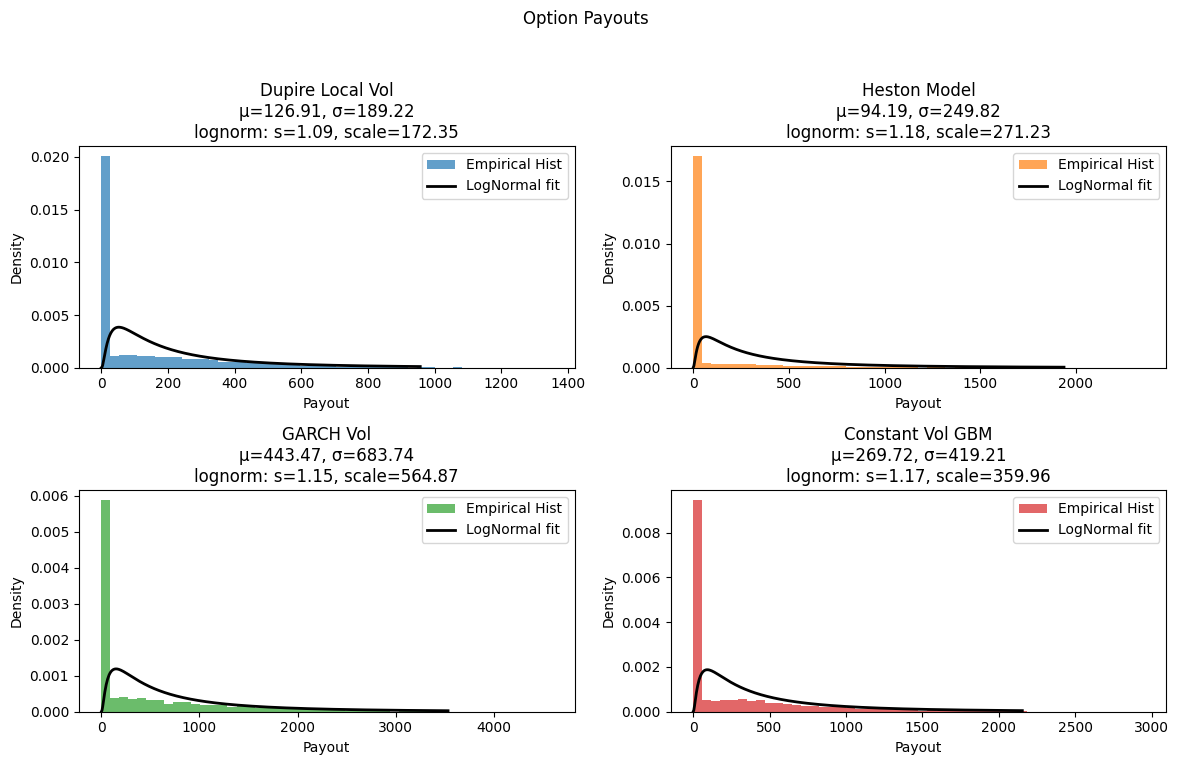

In [46]:
plot_log_norm(local_vol_payouts,heston_payouts,Garch_Vol_payouts,Constant_vol_payouts,'Option Payouts')

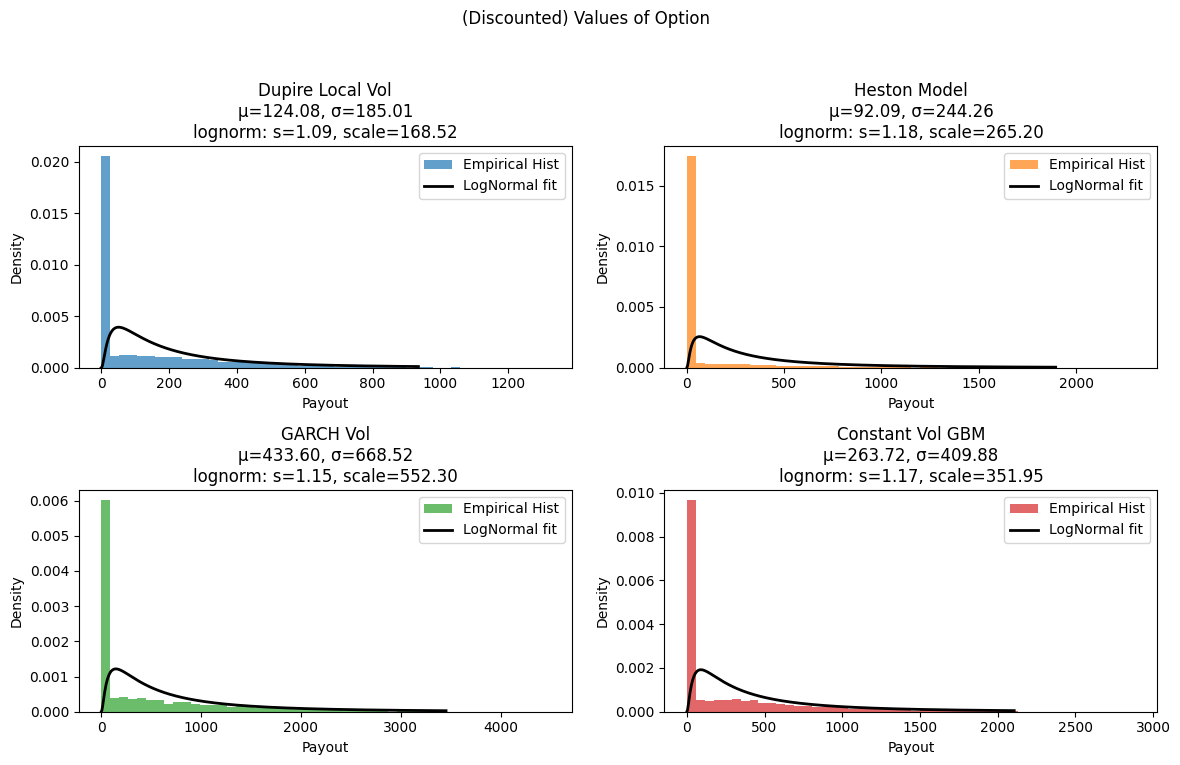

In [47]:
plot_log_norm(local_vol_val,heston_val,Garch_Vol_val,Constant_vol_val,'(Discounted) Values of Option')

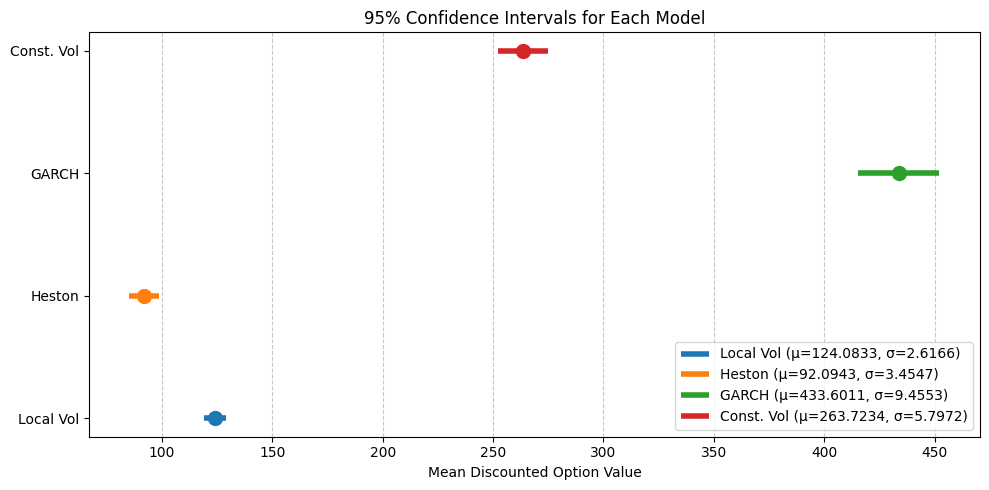

In [48]:
plot_CI(local_vol_val,heston_val,Garch_Vol_val,Constant_vol_val,alpha = 0.05)
